In [31]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.flop_counter import FlopCounterMode
import matplotlib.pyplot as plt
import contextlib
import sys

In [3]:
def load_text(filename):
    path = os.path.join('./datasets/tiny_shakespeare', filename)
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

txt_train=load_text('train.txt')
txt_test=load_text('test.txt')
txt_valid=load_text('valid.txt')

print(f"Lengths for train, test and valid are {len(txt_train)}, {len(txt_test)} and {len(txt_valid)} resp.")

Lengths for train, test and valid are 892117, 111606 and 111669 resp.


In [4]:
total_chars = sorted(list(set(txt_train+txt_test+txt_valid)))
vocab_sz = len(total_chars)
print(f"total vocab size if {vocab_sz}")

total vocab size if 65


In [54]:
stoi = {ch:i for i, ch in enumerate(total_chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode_text(text):
    return torch.tensor([stoi[ch] for ch in text], dtype=torch.long)

train_data = encode_text(txt_train)
test_data  = encode_text(txt_test)
valid_data = encode_text(txt_valid)

print(f"Shape of train, test and valid are {train_data.shape}, {test_data.shape} and {valid_data.shape} resp.")

Shape of train, test and valid are torch.Size([892117]), torch.Size([111606]) and torch.Size([111669]) resp.


In [49]:
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size
    def __len__(self):
        return len(self.data)-self.block_size
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.block_size]
        y = self.data[idx+self.block_size]
        return x, y

def get_loaders(block_size, batch_size):
    train_loader = DataLoader(CharDataset(train_data, block_size), batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(CharDataset(valid_data, block_size), batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader  = DataLoader(CharDataset(test_data, block_size), batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, valid_loader, test_loader

class LinearPredictorLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.block_size = block_size
        self.fc = nn.Linear(block_size*embed_dim, vocab_size)
    def forward(self, idx):
        B, T = idx.size()
        emb = self.embed(idx)
        flat = emb.view(B, T * emb.size(-1))
        logits = self.fc(flat)
        return logits

def run_linear_experiment(config):
    embed_dim = config['embed_dim']
    block_size = config['block_size']
    batch_size = config['batch_size']
    num_epochs = config['num_epochs']
    lr = config['lr']

    train_loader, valid_loader, test_loader = get_loaders(block_size, batch_size)
    model = LinearPredictorLM(vocab_sz, embed_dim, block_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []
    total_flops = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        cnt = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            with FlopCounterMode(model, display=False, depth=None) as fcm:
                logits = model(x)
                loss = nn.functional.cross_entropy(logits, y)
                loss.backward()
                flop_batch = fcm.get_total_flops()
                total_flops += flop_batch
            optimizer.step()

            running += loss.item() * y.size(0)
            cnt += y.size(0)

        train_loss = running/cnt
        train_losses.append(train_loss)

        model.eval()
        running_val = 0.0
        count_val = 0.0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                logits_val = model(x_val)
                loss_val = nn.functional.cross_entropy(logits_val, y_val)
                running_val += loss_val.item() * y_val.size(0)
                count_val += y_val.size(0)
        avg_val = running_val/count_val
        valid_losses.append(avg_val)
    
        print(f"Epoch - {epoch} | Train loss:- {train_loss:.4f} | Valid loss:- {avg_val:.4f} | FLOPs:- {total_flops}")

    model.eval()
    with torch.no_grad():
        total = 0.0
        cnt = 0.0
        for x, y in test_loader:
            logits = model(x)
            loss = nn.functional.cross_entropy(logits, y)
            total += loss.item()*y.size(0)
            cnt += y.size(0)
        test_loss = total / cnt
    print("Computed Value of Test Loss:", test_loss)
    test_log_likelihood = - test_loss

    result = {'config': config,'train_losses': train_losses,'test_loss': test_loss,'test_ll': test_log_likelihood,
              'total_flops': total_flops,'model': model}
    return result

# Testing with difference block size hyperparameter setting
exp_configs_1 = [ {'block_size': 16, 'batch_size': 128, 'embed_dim': vocab_sz, 'lr': 0.005, 'num_epochs': 20},
{'block_size': 32, 'batch_size': 128, 'embed_dim': vocab_sz, 'lr': 0.005, 'num_epochs': 20},
{'block_size': 64, 'batch_size': 128, 'embed_dim': vocab_sz, 'lr': 0.005, 'num_epochs': 20}]

print("Case 1: Testing different hyperparameter - context length (block_size).")
all_results_1 = []
for cfg in exp_configs_1:
    res = run_linear_experiment(cfg)
    all_results_1.append(res)

Case 1: Testing different hyperparameter - context length (block_size).


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/3937717864.py:65: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 2.2071 | Valid loss:- 2.2392 | FLOPs:- 361808179200
Epoch - 2 | Train loss:- 2.1217 | Valid loss:- 2.2420 | FLOPs:- 723616358400
Epoch - 3 | Train loss:- 2.1112 | Valid loss:- 2.2282 | FLOPs:- 1085424537600
Epoch - 4 | Train loss:- 2.1056 | Valid loss:- 2.2375 | FLOPs:- 1447232716800
Epoch - 5 | Train loss:- 2.1020 | Valid loss:- 2.2333 | FLOPs:- 1809040896000
Epoch - 6 | Train loss:- 2.1003 | Valid loss:- 2.2266 | FLOPs:- 2170849075200
Epoch - 7 | Train loss:- 2.0981 | Valid loss:- 2.2243 | FLOPs:- 2532657254400
Epoch - 8 | Train loss:- 2.0973 | Valid loss:- 2.2225 | FLOPs:- 2894465433600
Epoch - 9 | Train loss:- 2.0964 | Valid loss:- 2.2251 | FLOPs:- 3256273612800
Epoch - 10 | Train loss:- 2.0956 | Valid loss:- 2.2311 | FLOPs:- 3618081792000
Epoch - 11 | Train loss:- 2.0951 | Valid loss:- 2.2368 | FLOPs:- 3979889971200
Epoch - 12 | Train loss:- 2.0943 | Valid loss:- 2.2333 | FLOPs:- 4341698150400
Epoch - 13 | Train loss:- 2.0943 | Valid loss:- 2.2300 | FLOPs:

In [50]:
# Testing with difference lr hyperparameter setting
exp_configs_2 = [ {'block_size': 16, 'batch_size': 128, 'embed_dim': vocab_sz, 'lr': 0.001, 'num_epochs': 20},
{'block_size': 16, 'batch_size': 128, 'embed_dim': vocab_sz, 'lr': 0.005, 'num_epochs': 20},
{'block_size': 16, 'batch_size': 128, 'embed_dim': vocab_sz, 'lr': 0.010, 'num_epochs': 20}]

print("Case 2: Testing different hyperparameter - learning rate.")
all_results_2 = []
for cfg in exp_configs_2:
    res = run_linear_experiment(cfg)
    all_results_2.append(res)

Case 2: Testing different hyperparameter - learning rate.


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/3937717864.py:65: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 2.1998 | Valid loss:- 2.2244 | FLOPs:- 361808179200
Epoch - 2 | Train loss:- 2.0891 | Valid loss:- 2.2028 | FLOPs:- 723616358400
Epoch - 3 | Train loss:- 2.0648 | Valid loss:- 2.1948 | FLOPs:- 1085424537600
Epoch - 4 | Train loss:- 2.0510 | Valid loss:- 2.1844 | FLOPs:- 1447232716800
Epoch - 5 | Train loss:- 2.0412 | Valid loss:- 2.1833 | FLOPs:- 1809040896000
Epoch - 6 | Train loss:- 2.0347 | Valid loss:- 2.1796 | FLOPs:- 2170849075200
Epoch - 7 | Train loss:- 2.0295 | Valid loss:- 2.1802 | FLOPs:- 2532657254400
Epoch - 8 | Train loss:- 2.0259 | Valid loss:- 2.1761 | FLOPs:- 2894465433600
Epoch - 9 | Train loss:- 2.0223 | Valid loss:- 2.1804 | FLOPs:- 3256273612800
Epoch - 10 | Train loss:- 2.0198 | Valid loss:- 2.1720 | FLOPs:- 3618081792000
Epoch - 11 | Train loss:- 2.0174 | Valid loss:- 2.1676 | FLOPs:- 3979889971200
Epoch - 12 | Train loss:- 2.0155 | Valid loss:- 2.1668 | FLOPs:- 4341698150400
Epoch - 13 | Train loss:- 2.0140 | Valid loss:- 2.1687 | FLOPs:

In [51]:
# Testing with difference batch size hyperparameter setting
exp_configs_3 = [ {'block_size': 16, 'batch_size': 64, 'embed_dim': vocab_sz, 'lr': 0.001, 'num_epochs': 20},
{'block_size': 16, 'batch_size': 128, 'embed_dim': vocab_sz, 'lr': 0.001, 'num_epochs': 20},
{'block_size': 16, 'batch_size': 256, 'embed_dim': vocab_sz, 'lr': 0.001, 'num_epochs': 20}]

print("Case 3: Testing different hyperparameter - batch size.")
all_results_3 = []
for cfg in exp_configs_3:
    res = run_linear_experiment(cfg)
    all_results_3.append(res)

Case 3: Testing different hyperparameter - batch size.


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/3937717864.py:65: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 2.2044 | Valid loss:- 2.2387 | FLOPs:- 361834137600
Epoch - 2 | Train loss:- 2.0921 | Valid loss:- 2.2008 | FLOPs:- 723668275200
Epoch - 3 | Train loss:- 2.0646 | Valid loss:- 2.1941 | FLOPs:- 1085502412800
Epoch - 4 | Train loss:- 2.0500 | Valid loss:- 2.1832 | FLOPs:- 1447336550400
Epoch - 5 | Train loss:- 2.0415 | Valid loss:- 2.1815 | FLOPs:- 1809170688000
Epoch - 6 | Train loss:- 2.0358 | Valid loss:- 2.1802 | FLOPs:- 2171004825600
Epoch - 7 | Train loss:- 2.0314 | Valid loss:- 2.1796 | FLOPs:- 2532838963200
Epoch - 8 | Train loss:- 2.0279 | Valid loss:- 2.1713 | FLOPs:- 2894673100800
Epoch - 9 | Train loss:- 2.0255 | Valid loss:- 2.1699 | FLOPs:- 3256507238400
Epoch - 10 | Train loss:- 2.0234 | Valid loss:- 2.1726 | FLOPs:- 3618341376000
Epoch - 11 | Train loss:- 2.0217 | Valid loss:- 2.1710 | FLOPs:- 3980175513600
Epoch - 12 | Train loss:- 2.0203 | Valid loss:- 2.1727 | FLOPs:- 4342009651200
Epoch - 13 | Train loss:- 2.0193 | Valid loss:- 2.1663 | FLOPs:

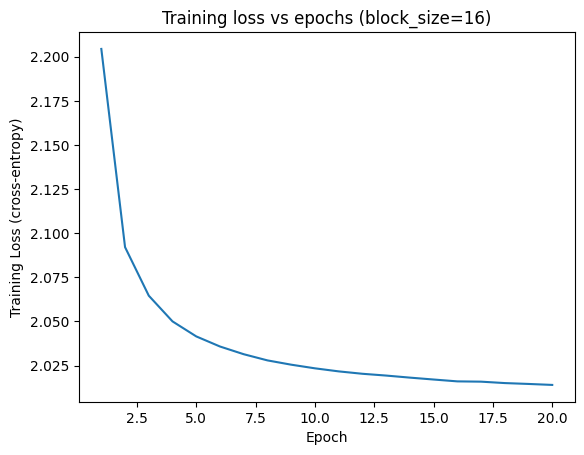

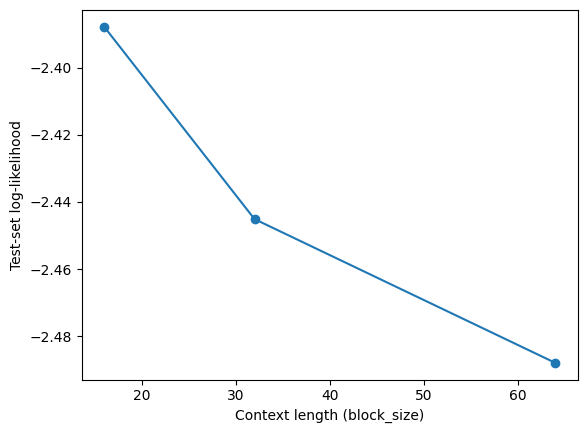

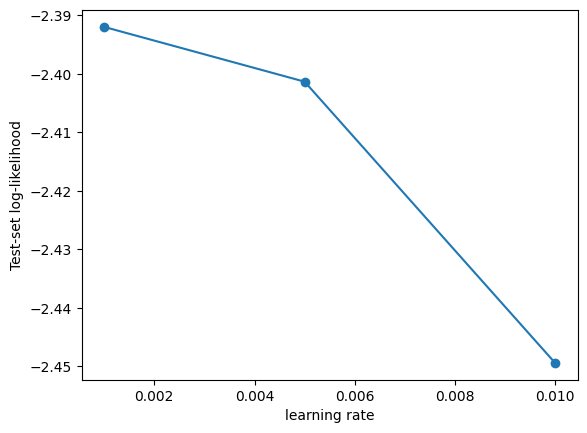

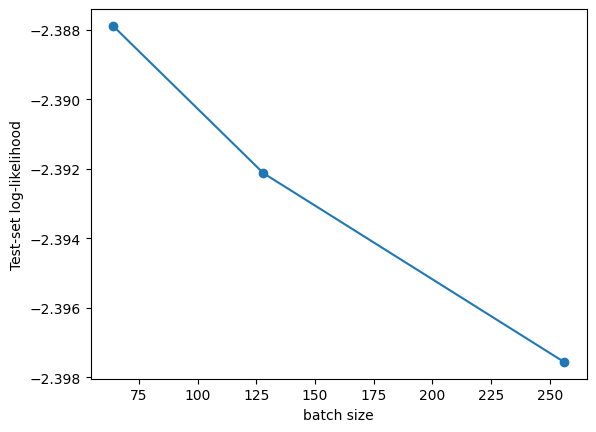

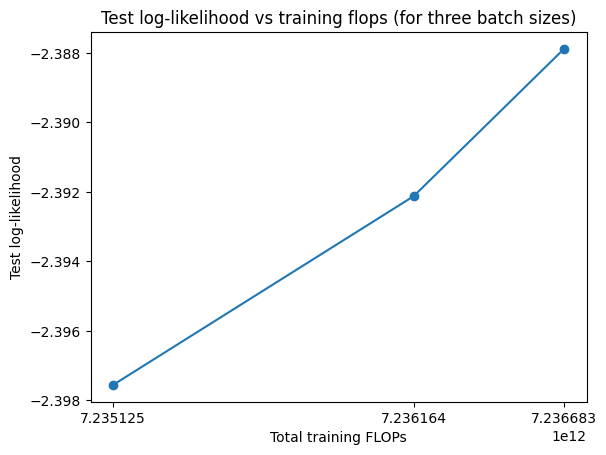

Best parameter setting found is: {'block_size': 16, 'batch_size': 64, 'embed_dim': 65, 'lr': 0.001, 'num_epochs': 20}
Generated text is: HAMLET:ar hit loull
And dois pentom:
Bof oalcemby
me ine by Yeak.
You wht be shall, As Liok say hresten nou


In [77]:
# 0.1 Reporting - Best Hyperparam setting found => lr=0.001 batch_size=64 block_size=16

# 0.2 Plot of training loss vs epochs
first = all_results_3[0]
plt.figure()
plt.plot(range(1, len(first['train_losses'])+1), first['train_losses'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss (cross-entropy)')
plt.title(f"Training loss vs epochs (block_size={first['config']['block_size']})")
plt.show()

# plot of test log-likelihood v/s hyperparameter (block_size)
plt.figure()
blocks = [r['config']['block_size'] for r in all_results_1]
test_lls = [r['test_ll'] for r in all_results_1]
plt.plot(blocks, test_lls, marker='o')
plt.xlabel('Context length (block_size)')
plt.ylabel('Test-set log-likelihood')
plt.show()

# plot of test log-likelihood v/s hyperparameter (learning_rate)
plt.figure()
blocks = [r['config']['lr'] for r in all_results_2]
test_lls = [r['test_ll'] for r in all_results_2]
plt.plot(blocks, test_lls, marker='o')
plt.xlabel('learning rate')
plt.ylabel('Test-set log-likelihood')
plt.show()

# plot of test log-likelihood v/s hyperparameter (batch size)
plt.figure()
blocks = [r['config']['batch_size'] for r in all_results_3]
test_lls = [r['test_ll'] for r in all_results_3]
plt.plot(blocks, test_lls, marker='o')
plt.xlabel('batch size')
plt.ylabel('Test-set log-likelihood')
plt.show()

# plot for test log- likelihood v/s FLOPs
plt.figure()
flps = [r['total_flops'] for r in all_results_3]
plt.plot(flps, test_lls, marker='o')
plt.xticks(flps) 
plt.xlabel('Total training FLOPs')
plt.ylabel('Test log-likelihood')
plt.title('Test log-likelihood vs training flops (for three batch sizes)')
plt.show()

best = max(all_results_3, key=lambda p: p['test_ll'])
best_model = best['model']

def generate_text(model, prompt, max_tok, block_size, stoi, itos):
    model.eval()
    context = [stoi.get(ch, 0) for c in prompt for ch in c] if isinstance(prompt, list) else [stoi.get(ch, 0) for ch in prompt]
    for _ in range(max_tok):
        context_trunc = context[-block_size:]
        if len(context_trunc) < block_size:
            context_trunc = [0]*(block_size-len(context_trunc))+context_trunc
        x = torch.tensor([context_trunc], dtype=torch.long)
        logits = model(x)
        last_logits = logits[0]
        probs = torch.softmax(last_logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        context.append(next_id)
    return ''.join([itos[i] for i in context])
    
sample = generate_text(best_model, prompt="HAMLET:", max_tok=100, block_size=best['config']['block_size'], stoi=stoi, itos=itos)
print("Best parameter setting found is:", best['config'])
print("Generated text is:", sample)

In [86]:
# Second Architecture - MLP LM
class MLP_LM(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, hidden_dims):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.block_size = block_size
        layers = []
        input_dim = block_size*embed_dim
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, vocab_size))
        self.net = nn.Sequential(*layers)
    def forward(self, idx):
        B, T = idx.size()
        emb = self.embed(idx)
        flat = emb.view(B, T*emb.size(-1))
        logits = self.net(flat)
        return logits

def run_mlp_experiment(config, data_train, data_valid, data_test, vocab_size, stoi, itos):
    embed_dim = config['embed_dim']
    block_size = config['block_size']
    batch_size = config['batch_size']
    hidden_dims = config['hidden_dims']
    lr = config['lr']
    num_epochs = config['num_epochs']

    train_loader, valid_loader, test_loader = get_loaders(block_size, batch_size)
    model = MLP_LM(vocab_size, embed_dim, block_size, hidden_dims)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []
    total_flops = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        cnt = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            with FlopCounterMode(model, display=False, depth=None) as fcm:
                logits = model(x)
                loss = nn.functional.cross_entropy(logits, y)
                loss.backward()
                flop_batch = fcm.get_total_flops()
                total_flops += flop_batch
            optimizer.step()

            running += loss.item() * y.size(0)
            cnt += y.size(0)

        train_loss = running/cnt
        train_losses.append(train_loss)

        model.eval()
        running_val = 0.0
        count_val = 0.0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                logits_val = model(x_val)
                loss_val = nn.functional.cross_entropy(logits_val, y_val)
                running_val += loss_val.item() * y_val.size(0)
                count_val += y_val.size(0)
        avg_val = running_val/count_val
        valid_losses.append(avg_val)
    
        print(f"Epoch - {epoch} | Train loss:- {train_loss:.4f} | Valid loss:- {avg_val:.4f} | FLOPs:- {total_flops}")

    model.eval()
    with torch.no_grad():
        total = 0.0
        cnt = 0.0
        for x, y in test_loader:
            logits = model(x)
            loss = nn.functional.cross_entropy(logits, y)
            total += loss.item()*y.size(0)
            cnt += y.size(0)
        test_loss = total/cnt
    print("Computed Value of Test Loss:", test_loss)
    test_log_likelihood = - test_loss

    result = {'config': config,'train_losses': train_losses,'valid_losses': valid_losses,'test_loss': test_loss,
              'test_ll': test_log_likelihood, 'total_flops': total_flops,'model': model}
    return result

exp_configs_mlp_1 = [{'block_size': 16, 'batch_size': 128, 'embed_dim': 128, 'hidden_dims': [64, 64], 'lr': 0.001, 'num_epochs': 20},
    {'block_size': 32, 'batch_size': 128, 'embed_dim': 128, 'hidden_dims': [64, 64], 'lr': 0.001, 'num_epochs': 20},
    {'block_size': 64, 'batch_size': 128, 'embed_dim': 128, 'hidden_dims': [64, 64], 'lr': 0.001, 'num_epochs': 20},]

print("Testing different hyperparameter - context length (block_size).")
all_results_mlp_1 = []
for cfg in exp_configs_mlp_1:
    res = run_mlp_experiment(cfg, train_data, valid_data, test_data, vocab_sz, stoi, itos)
    all_results_mlp_1.append(res)

Testing different hyperparameter - context length (block_size).


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/2475138574.py:44: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 1.9370 | Valid loss:- 1.8868 | FLOPs:- 745710206976
Epoch - 2 | Train loss:- 1.7265 | Valid loss:- 1.8425 | FLOPs:- 1491420413952
Epoch - 3 | Train loss:- 1.6745 | Valid loss:- 1.8172 | FLOPs:- 2237130620928
Epoch - 4 | Train loss:- 1.6458 | Valid loss:- 1.8034 | FLOPs:- 2982840827904
Epoch - 5 | Train loss:- 1.6271 | Valid loss:- 1.7952 | FLOPs:- 3728551034880
Epoch - 6 | Train loss:- 1.6136 | Valid loss:- 1.8007 | FLOPs:- 4474261241856
Epoch - 7 | Train loss:- 1.6027 | Valid loss:- 1.8022 | FLOPs:- 5219971448832
Epoch - 8 | Train loss:- 1.5943 | Valid loss:- 1.7916 | FLOPs:- 5965681655808
Epoch - 9 | Train loss:- 1.5873 | Valid loss:- 1.7898 | FLOPs:- 6711391862784
Epoch - 10 | Train loss:- 1.5813 | Valid loss:- 1.7966 | FLOPs:- 7457102069760
Epoch - 11 | Train loss:- 1.5763 | Valid loss:- 1.7925 | FLOPs:- 8202812276736
Epoch - 12 | Train loss:- 1.5714 | Valid loss:- 1.7885 | FLOPs:- 8948522483712
Epoch - 13 | Train loss:- 1.5677 | Valid loss:- 1.7950 | FLOPs

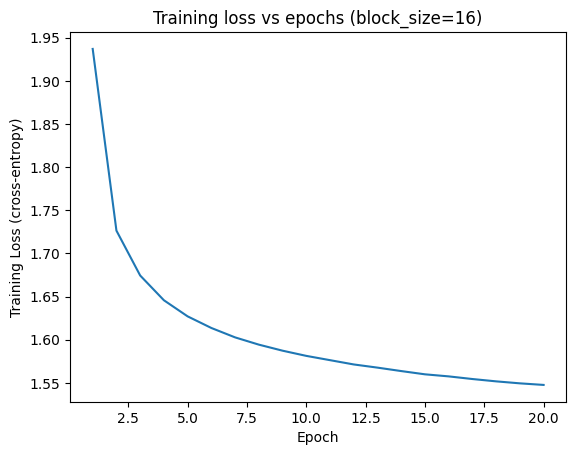

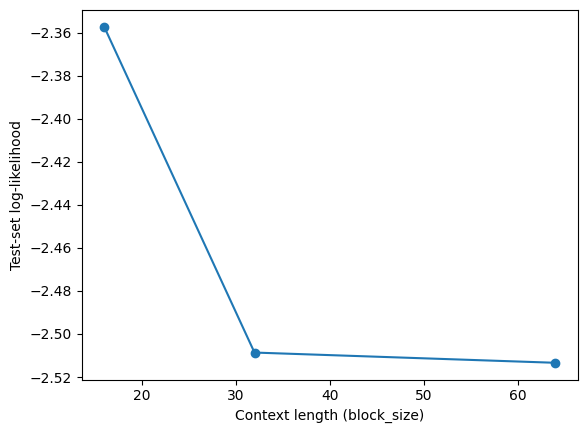

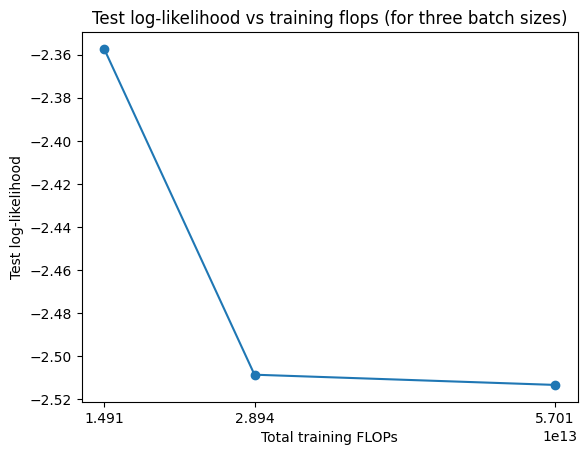

Best parameter setting found is: {'block_size': 16, 'batch_size': 128, 'embed_dim': 128, 'hidden_dims': [64, 64], 'lr': 0.001, 'num_epochs': 20}
Generated text is: HAMLET:AY:
He plant thousand uncurrland.

CAMILLO:
Nevel?

WARWICK:
It one joints wine
my eneedmen take,
Or


In [123]:
# 0.1 Reporting - Best Hyperparam setting found => {'block_size': 16, 'batch_size': 128, 'embed_dim': 128, 'hidden_dims': [64, 64], 'lr': 0.001, 'num_epochs': 20}

# 0.2 Plot of training loss vs epochs
first = all_results_mlp_1[0]
plt.figure()
plt.plot(range(1, len(first['train_losses'])+1), first['train_losses'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss (cross-entropy)')
plt.title(f"Training loss vs epochs (block_size={first['config']['block_size']})")
plt.show()

# plot of test log-likelihood v/s hyperparameter (block_size)
plt.figure()
blocks = [r['config']['block_size'] for r in all_results_mlp_1]
test_lls = [r['test_ll'] for r in all_results_mlp_1]
plt.plot(blocks, test_lls, marker='o')
plt.xlabel('Context length (block_size)')
plt.ylabel('Test-set log-likelihood')
plt.show()

# plot for test log- likelihood v/s FLOPs
plt.figure()
flps = [r['total_flops'] for r in all_results_mlp_1]
plt.plot(flps, test_lls, marker='o')
plt.xticks(flps)
plt.xlabel('Total training FLOPs')
plt.ylabel('Test log-likelihood')
plt.title('Test log-likelihood vs training flops (for three batch sizes)')
plt.show()

best_model = all_results_mlp_1[0]['model']

def generate_text_mlp(model, prompt, max_tok, block_size, stoi, itos):
    model.eval()
    context = [stoi.get(ch, 0) for ch in prompt]
    generated = context[:]
    for _ in range(max_tok):
        gen_dat = generated[-block_size:]
        if len(gen_dat) < block_size:
            gen_dat = [0] * (block_size - len(gen_dat)) + gen_dat
        x = torch.tensor([gen_dat], dtype=torch.long)
        logits = model(x)
        probs = torch.softmax(logits[0], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_id)
    return ''.join([itos[i] for i in generated])
    
sample = generate_text_mlp(best_model, prompt="HAMLET:", max_tok=100, block_size=best['config']['block_size'], stoi=stoi, itos=itos)
print("Best parameter setting found is:", all_results_mlp_1[0]['config'])
print("Generated text is:", sample)

In [126]:
## 3. Self Attention LM Model ##
class SelfAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)
    def forward(self, x, attn_mask):
        resi=x
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = resi+attn_out
        x = self.ln(x)
        return x

class SelfAttentionLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, num_heads, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(block_size, embed_dim)
        self.blocks = nn.ModuleList([SelfAttentionBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.ln_final = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, idx):
        B, T = idx.size()
        positions = torch.arange(T, dtype=torch.long)[None, :].expand(B, T)
        x = self.token_emb(idx) + self.pos_emb(positions)
        T = idx.size(1)
        mask = torch.triu(torch.ones((T, T), dtype=torch.bool, device=idx.device), diagonal=1)
        for block in self.blocks:
            x = block(x, attn_mask=mask)
        x = self.ln_final(x)
        logits = self.fc_out(x)
        return logits

def run_self_attention_experiment(config, data_train, data_valid, data_test, vocab_size, stoi, itos):
    embed_dim = config['embed_dim']
    block_size = config['block_size']
    batch_size = config['batch_size']
    num_heads = config['num_heads']
    num_layers = config['num_layers']
    lr = config['lr']
    num_epochs = config['num_epochs']

    train_loader, valid_loader, test_loader = get_loaders(block_size, batch_size)
    model = SelfAttentionLM(vocab_size, embed_dim, block_size, num_heads, num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []
    total_flops = 0
    
    flop_x, _ = next(iter(train_loader))
    model.eval()
    with FlopCounterMode(model, display=False, depth=None) as fcm:
        logits = model(flop_x)
        logits_l = logits[:, -1, :]
    flops_per_forward = fcm.get_total_flops()
    flops_per_train_step = 2 * flops_per_forward
    steps_per_epoch = len(train_loader)
    total_flops = flops_per_train_step*steps_per_epoch*num_epochs

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        cnt = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            logits = model(x)
            logits_l = logits[:, -1, :]
            loss = nn.functional.cross_entropy(logits_l, y)
            loss.backward()
            optimizer.step()

            running += loss.item() * y.size(0)
            cnt += y.size(0)

        train_loss = running/cnt
        train_losses.append(train_loss)

        model.eval()
        running_val = 0.0
        count_val = 0.0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                logits_val = model(x_val)
                logits_val_l = logits_val[:, -1, :]
                loss_val = nn.functional.cross_entropy(logits_val_l, y_val)
                running_val += loss_val.item() * y_val.size(0)
                count_val += y_val.size(0)
        avg_val = running_val/count_val
        valid_losses.append(avg_val)
    
        print(f"Epoch - {epoch} | Train loss:- {train_loss:.4f} | Valid loss:- {avg_val:.4f} | FLOPs:- {total_flops}")

    model.eval()
    with torch.no_grad():
        total = 0.0
        cnt = 0.0
        for x, y in test_loader:
            logits = model(x)
            logits_l = logits[:, -1, :]
            loss = nn.functional.cross_entropy(logits_l, y)
            total += loss.item()*y.size(0)
            cnt += y.size(0)
        test_loss = total/cnt
    print("Computed Value of Test Loss:", test_loss)
    test_log_likelihood = - test_loss

    result = {'config': config,'train_losses': train_losses,'valid_losses': valid_losses,'test_loss': test_loss,
              'test_ll': test_log_likelihood, 'total_flops': total_flops,'model': model}
    return result

exp_configs_self_att_1 = [{'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'num_heads': 2, 'num_layers': 2, 'lr': 0.005, 'num_epochs': 20},
    {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'num_heads': 4, 'num_layers': 2, 'lr': 0.005, 'num_epochs': 20},
    {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'num_heads': 8, 'num_layers': 2, 'lr': 0.005, 'num_epochs': 20},]

print("Testing different hyperparameter - number of heads.")
all_results_self_att_1 = []
for cfg in exp_configs_self_att_1:
    res = run_self_attention_experiment(cfg, train_data, valid_data, test_data, vocab_sz, stoi, itos)
    all_results_self_att_1.append(res)

Testing different hyperparameter - number of heads.


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/3448255507.py:54: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 2.1440 | Valid loss:- 2.1177 | FLOPs:- 46844603269120
Epoch - 2 | Train loss:- 2.0256 | Valid loss:- 2.1076 | FLOPs:- 46844603269120
Epoch - 3 | Train loss:- 2.0071 | Valid loss:- 2.1019 | FLOPs:- 46844603269120
Epoch - 4 | Train loss:- 2.0259 | Valid loss:- 2.1901 | FLOPs:- 46844603269120
Epoch - 5 | Train loss:- 2.0552 | Valid loss:- 2.1209 | FLOPs:- 46844603269120
Epoch - 6 | Train loss:- 2.0402 | Valid loss:- 2.0866 | FLOPs:- 46844603269120
Epoch - 7 | Train loss:- 2.0107 | Valid loss:- 2.0819 | FLOPs:- 46844603269120
Epoch - 8 | Train loss:- 1.9957 | Valid loss:- 2.1107 | FLOPs:- 46844603269120
Epoch - 9 | Train loss:- 2.0149 | Valid loss:- 2.1668 | FLOPs:- 46844603269120
Epoch - 10 | Train loss:- 2.0194 | Valid loss:- 2.1099 | FLOPs:- 46844603269120
Epoch - 11 | Train loss:- 2.0278 | Valid loss:- 2.1127 | FLOPs:- 46844603269120
Epoch - 12 | Train loss:- 2.0343 | Valid loss:- 2.1043 | FLOPs:- 46844603269120
Epoch - 13 | Train loss:- 2.0275 | Valid loss:- 2

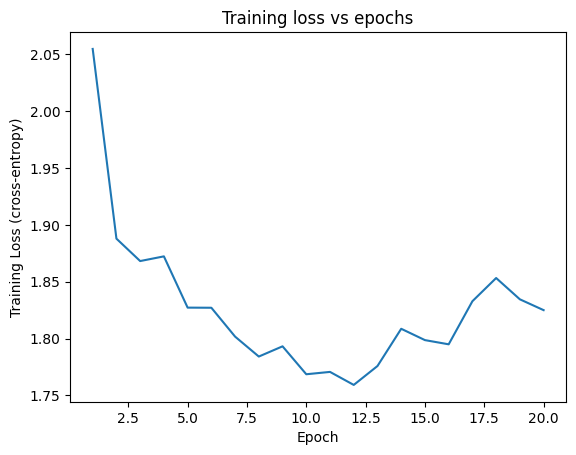

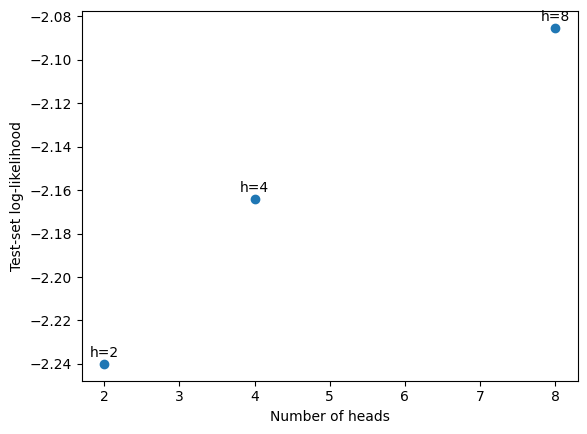

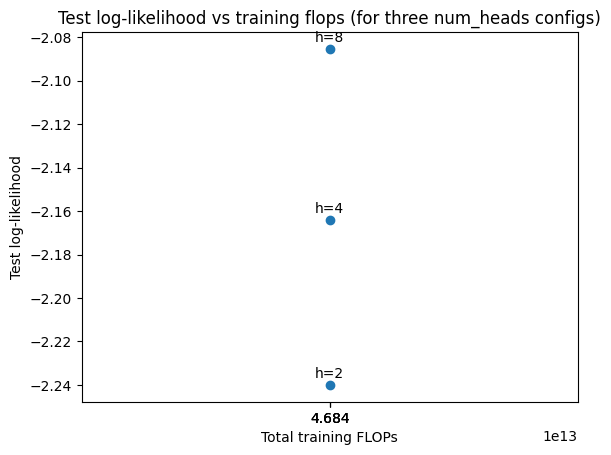

Best parameter setting found is: {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'num_heads': 8, 'num_layers': 2, 'lr': 0.005, 'num_epochs': 20}
Generated text is: HAMLET:
He it hall, our speins?

FRITER; I with buls, anting, wease sheom's is I'll pear so, givessectent.



In [139]:
# 0.1 Reporting - Best Hyperparam setting found => {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'num_heads': 8, 'num_layers': 2, 'lr': 0.005, 'num_epochs': 20},]

# 0.2 Plot of training loss vs epochs
first = all_results_self_att_1[2]
plt.figure()
plt.plot(range(1, len(first['train_losses'])+1), first['train_losses'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss (cross-entropy)')
plt.title("Training loss vs epochs")
plt.show()

# plot of test log-likelihood v/s hyperparameter (number of heads)
num_heads = [r['config']['num_heads'] for r in all_results_self_att_1]
labels = [f"h={r['config']['num_heads']}" for r in all_results_self_att_1]

plt.figure()
test_lls = [r['test_ll'] for r in all_results_self_att_1]
for x, y, lab in zip(num_heads, test_lls, labels):
    plt.annotate(lab, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.scatter(num_heads, test_lls)
plt.xlabel('Number of heads')
plt.ylabel('Test-set log-likelihood')
plt.show()


# plot for test log- likelihood v/s FLOPs
plt.figure()
flps = [r['total_flops'] for r in all_results_self_att_1]
for x, y, lab in zip(flps, test_lls, labels):
    plt.annotate(lab, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.scatter(flps, test_lls)
plt.xticks(flps)
plt.xlabel('Total training FLOPs')
plt.ylabel('Test log-likelihood')
plt.title('Test log-likelihood vs training flops (for three num_heads configs)')
plt.show()

best_model = all_results_self_att_1[2]['model']

def generate_text_self_attn(model, prompt, max_tok, block_size, stoi, itos):
    model.eval()
    context = [stoi.get(ch, 0) for ch in prompt]
    generated = context[:]
    for _ in range(max_tok):
        gen_dat = generated[-block_size:]
        if len(gen_dat) < block_size:
            gen_dat = [0] * (block_size - len(gen_dat)) + gen_dat
        x = torch.tensor([gen_dat], dtype=torch.long)
        logits = model(x)
        logits_l = logits[:, -1, :]
        probs = torch.softmax(logits_l[0], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_id)
    return ''.join([itos[i] for i in generated])
    
sample = generate_text_self_attn(best_model, prompt="HAMLET:", max_tok=100, block_size=best['config']['block_size'], stoi=stoi, itos=itos)
print("Best parameter setting found is:", all_results_self_att_1[2]['config'])
print("Generated text is:", sample)

In [142]:
### 4. Multi-layer transformer - A small transformer with multiple blocks. ###
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(nn.Linear(embed_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, embed_dim),)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x, attn_mask):
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = x + attn_out
        x = self.ln1(x)
        ff_out = self.ff(x)
        x = x + ff_out
        x = self.ln2(x)
        return x

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, num_heads, num_layers, hidden_dim):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.posi_emb = nn.Embedding(block_size, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads, hidden_dim) for _ in range(num_layers)])
        self.ln_final = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, idx):
        B, T = idx.size()
        positions = torch.arange(T, dtype=torch.long, device=idx.device)
        positions = positions.unsqueeze(0).expand(B, T)
        x = self.token_emb(idx) + self.posi_emb(positions)

        T = idx.size(1)
        mask = torch.triu(
            torch.ones((T, T), dtype=torch.bool, device=idx.device),
            diagonal=1
        )

        for block in self.blocks:
            x = block(x, attn_mask=mask)

        x = self.ln_final(x)
        logits = self.fc_out(x)
        return logits

def run_transformer_experiment(config, data_train, data_valid, data_test, vocab_size, stoi, itos):
    batch_size = config['batch_size']
    num_heads  = config['num_heads']
    embed_dim  = config['embed_dim']
    block_size = config['block_size']
    num_layers = config['num_layers']
    hidden_dim = config['hidden_dim']
    lr = config['lr']
    num_epochs = config['num_epochs']

    train_loader, valid_loader, test_loader = get_loaders(block_size, batch_size)

    model = TransformerLM(vocab_size=vocab_size,embed_dim=embed_dim,block_size=block_size, num_heads=num_heads, num_layers=num_layers,hidden_dim=hidden_dim,).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []

    flop_per_batch = None
    num_train_batches = len(train_loader)
    total_flops = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        cnt = 0

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            if flop_per_batch is None and i == 0:
                with FlopCounterMode(model, display=False, depth=None) as fcm:
                    logits = model(x)
                    logits_l = logits[:, -1, :]
                    loss = nn.functional.cross_entropy(logits_l, y)
                    loss.backward()
                flop_per_batch = fcm.get_total_flops()
                total_flops = flop_per_batch * num_train_batches * num_epochs
            else:
                logits = model(x)
                logits_l = logits[:, -1, :]
                loss = nn.functional.cross_entropy(logits_l, y)
                loss.backward()

            optimizer.step()

            running += loss.item() * y.size(0)
            cnt += y.size(0)

        train_loss = running/cnt
        train_losses.append(train_loss)

        model.eval()
        running_val = 0.0
        count_val = 0.0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                logits_val = model(x_val)
                logits_val_l = logits_val[:, -1, :]
                loss_val = nn.functional.cross_entropy(logits_val_l, y_val)
                running_val += loss_val.item() * y_val.size(0)
                count_val += y_val.size(0)
        avg_val = running_val / count_val
        valid_losses.append(avg_val)

        print(f"Epoch - {epoch} | Train loss:- {train_loss:.4f} | Valid loss:- {avg_val:.4f} | FLOPs (Total):- {total_flops}")

    model.eval()
    with torch.no_grad():
        total = 0.0
        cnt = 0.0
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            logits_l = logits[:, -1, :]
            loss = nn.functional.cross_entropy(logits_l, y)
            total += loss.item() * y.size(0)
            cnt += y.size(0)
        test_loss = total/cnt

    print("Computed Value of Test Loss:", test_loss)
    test_log_likelihood = -test_loss

    result = {
        'config': config,
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'test_loss': test_loss,
        'test_ll': test_log_likelihood,
        'total_flops': total_flops,
        'model': model,
    }
    return result

exp_configs_transformer_1 = [{'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'hidden_dim': 128, 'num_heads': 2, 'num_layers': 2, 'lr': 0.001, 'num_epochs': 20},
    {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'hidden_dim': 128, 'num_heads': 4, 'num_layers': 2, 'lr': 0.001, 'num_epochs': 20},
    {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 2, 'lr': 0.001, 'num_epochs': 20},]

print("Testing different hyperparameter - number of heads (Transformer).")
all_results_transformer_1 = []
for cfg in exp_configs_transformer_1:
    res = run_transformer_experiment(cfg, train_data, valid_data, test_data, vocab_sz, stoi, itos)
    all_results_transformer_1.append(res)

mps
Testing different hyperparameter - number of heads (Transformer).


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/2284400229.py:87: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 1.8765 | Valid loss:- 1.8301 | FLOPs (Total):- 46808063016960
Epoch - 2 | Train loss:- 1.6723 | Valid loss:- 1.7691 | FLOPs (Total):- 46808063016960
Epoch - 3 | Train loss:- 1.6228 | Valid loss:- 1.7421 | FLOPs (Total):- 46808063016960
Epoch - 4 | Train loss:- 1.5965 | Valid loss:- 1.7248 | FLOPs (Total):- 46808063016960
Epoch - 5 | Train loss:- 1.5787 | Valid loss:- 1.7144 | FLOPs (Total):- 46808063016960
Epoch - 6 | Train loss:- 1.5651 | Valid loss:- 1.7099 | FLOPs (Total):- 46808063016960
Epoch - 7 | Train loss:- 1.5544 | Valid loss:- 1.6966 | FLOPs (Total):- 46808063016960
Epoch - 8 | Train loss:- 1.5456 | Valid loss:- 1.6927 | FLOPs (Total):- 46808063016960
Epoch - 9 | Train loss:- 1.5383 | Valid loss:- 1.7009 | FLOPs (Total):- 46808063016960
Epoch - 10 | Train loss:- 1.5312 | Valid loss:- 1.6921 | FLOPs (Total):- 46808063016960
Epoch - 11 | Train loss:- 1.5267 | Valid loss:- 1.6824 | FLOPs (Total):- 46808063016960
Epoch - 12 | Train loss:- 1.5214 | Valid 

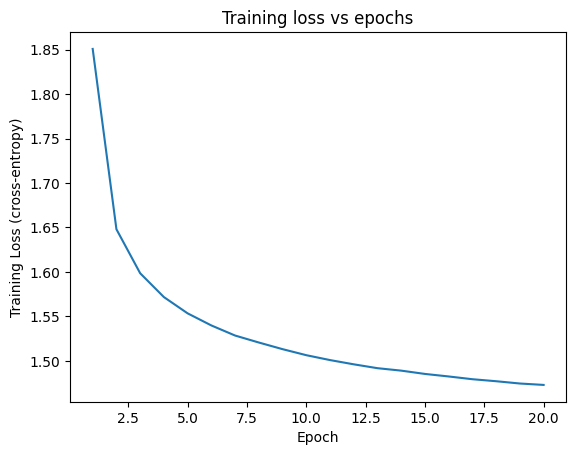

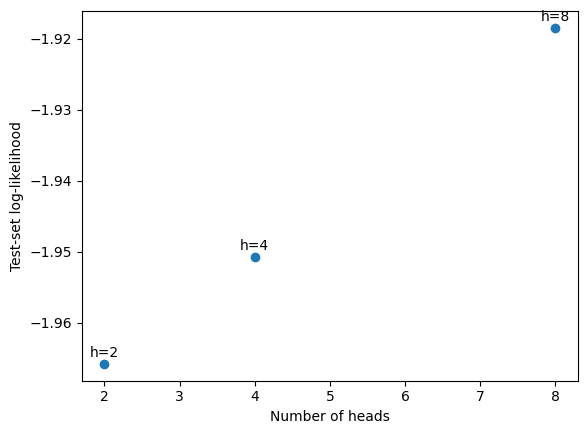

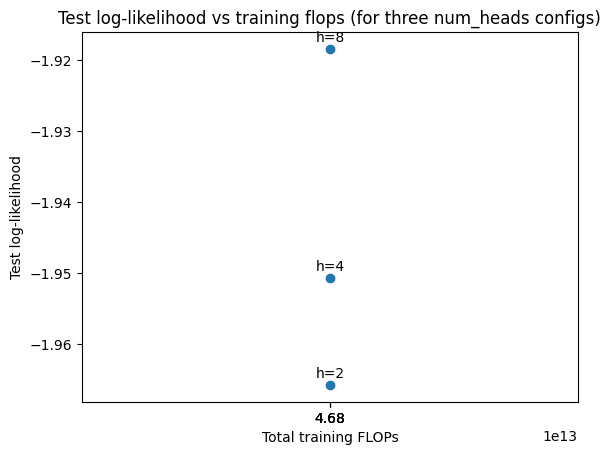

Best parameter setting found is: {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 2, 'lr': 0.001, 'num_epochs': 20}
Generated text is:
 HAMLET:
Anl incheea face.
Do not nece the baid to please me. They who stays of thinning: net pardown to, yo


In [169]:
# 0.1 Reporting - Best Hyperparam setting found => {'block_size': 16, 'batch_size': 64, 'embed_dim': 64, 'hidden_dim': 128, 'num_heads': 8, 'num_layers': 2, 'lr': 0.001, 'num_epochs': 20},]
# 0.2 Plot of training loss vs epochs
first = all_results_transformer_1[2]
plt.figure()
plt.plot(range(1, len(first['train_losses'])+1), first['train_losses'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss (cross-entropy)')
plt.title("Training loss vs epochs")
plt.show()

# plot of test log-likelihood v/s hyperparameter (number of heads)
num_heads = [r['config']['num_heads'] for r in all_results_transformer_1]
labels = [f"h={r['config']['num_heads']}" for r in all_results_transformer_1]

plt.figure()
test_lls = [r['test_ll'] for r in all_results_transformer_1]
for x, y, lab in zip(num_heads, test_lls, labels):
    plt.annotate(lab, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.scatter(num_heads, test_lls)
plt.xlabel('Number of heads')
plt.ylabel('Test-set log-likelihood')
plt.show()


# plot for test log- likelihood v/s FLOPs
plt.figure()
flps = [r['total_flops'] for r in all_results_transformer_1]
for x, y, lab in zip(flps, test_lls, labels):
    plt.annotate(lab, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.scatter(flps, test_lls)
plt.xticks(flps)
plt.xlabel('Total training FLOPs')
plt.ylabel('Test log-likelihood')
plt.title('Test log-likelihood vs training flops (for three num_heads configs)')
plt.show()

best_model = all_results_transformer_1[2]['model']

def generate_transformer_attn(model, prompt, max_tok, block_size, stoi, itos):
    model.eval()
    context = [stoi.get(ch, 0) for ch in prompt]
    generated = context[:]
    for _ in range(max_tok):
        gen_dat = generated[-block_size:]
        if len(gen_dat) < block_size:
            gen_dat = [0] * (block_size - len(gen_dat)) + gen_dat
        x = torch.tensor([gen_dat], dtype=torch.long, device=device)
        logits = model(x)
        logits_l = logits[:, -1, :].detach().cpu()
        probs = torch.softmax(logits_l[0], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_id)
    return ''.join([itos[i] for i in generated])
    
sample = generate_transformer_attn(best_model, prompt="HAMLET:", max_tok=100, block_size=best['config']['block_size'], stoi=stoi, itos=itos)
print("Best parameter setting found is:", all_results_transformer_1[2]['config'])
print("Generated text is:\n",sample)

In [ ]:
#### Question 2 ####
class WordDataset(Dataset):
    def __init__(self, data_ids, block_size):
        self.data = data_ids
        self.block_size = block_size
    def __len__(self):
        return len(self.data)-self.block_size
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.block_size]
        y = self.data[idx+self.block_size]
        return x,y

def get_loaders_word(train_data, valid_data, test_data, block_size, batch_size):
    train_loader = DataLoader(WordDataset(train_data, block_size), batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(WordDataset(valid_data, block_size), batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader  = DataLoader(WordDataset(test_data, block_size), batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, valid_loader, test_loader

def build_encode_word_vocab(texts):
    token_lists = [t.strip().split() for t in texts]

    all_tokens = []
    for tl in token_lists:
        all_tokens.extend(tl)
    vocab = sorted(set(all_tokens))
    stoi = {w: i for i, w in enumerate(vocab)}
    itos = {i: w for w, i in stoi.items()}
    encoded = []
    for tl in token_lists:
        ids = [stoi[w] for w in tl]
        encoded.append(torch.tensor(ids, dtype=torch.long))
    return stoi, itos, encoded


def load_word_dataset(base_dir):
    with open(os.path.join(base_dir, "train.txt"), "r", encoding="utf-8") as f:
        train_text = f.read()
    with open(os.path.join(base_dir, "valid.txt"), "r", encoding="utf-8") as f:
        valid_text = f.read()
    with open(os.path.join(base_dir, "test.txt"), "r", encoding="utf-8") as f:
        test_text = f.read()

    stoi, itos, (train_ids, valid_ids, test_ids) = build_encode_word_vocab([train_text, valid_text, test_text])
    vocab_size = len(stoi)
    return train_ids, valid_ids, test_ids, stoi, itos, vocab_size

ptb_dir = "datasets/ptb"
wiki2_dir = "datasets/wikitext-2"

ptb_train, ptb_valid, ptb_test, ptb_stoi, ptb_itos, ptb_vocab = load_word_dataset(ptb_dir)
wt_train, wt_valid, wt_test, wt_stoi, wt_itos, wt_vocab = load_word_dataset(wiki2_dir)

def run_transformer_experiment_word_dataset(config, train_data, valid_data, test_data, vocab_size):
    hidden_dim = config['hidden_dim']
    num_heads = config['num_heads']
    num_layers = config['num_layers']
    block_size = config['block_size']
    batch_size = config['batch_size']
    embed_dim = config['embed_dim']
    lr = config['lr']
    num_epochs = config['num_epochs']

    train_loader, valid_loader, test_loader = get_loaders_word(train_data, valid_data, test_data, block_size, batch_size)

    model = TransformerLM(vocab_size, embed_dim, block_size, num_heads, num_layers, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []
    total_flops = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running = 0.0
        cnt = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            with FlopCounterMode(model, display=False, depth=None) as fcm:
                logits = model(x)
                logits_l = logits[:, -1, :]
                loss = nn.functional.cross_entropy(logits_l, y)
                loss.backward()
                flop_batch = fcm.get_total_flops()
                total_flops += flop_batch

            optimizer.step()

            running += loss.item() * y.size(0)
            cnt += y.size(0)

        train_loss = running/cnt
        train_losses.append(train_loss)

        model.eval()
        running_val = 0.0
        count_val   = 0.0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                logits_val = model(x_val)
                logits_val_l = logits_val[:, -1, :]
                loss_val = nn.functional.cross_entropy(logits_val_l, y_val)
                running_val += loss_val.item() * y_val.size(0)
                count_val += y_val.size(0)
        avg_val = running_val / count_val
        valid_losses.append(avg_val)

        print(f"Epoch - {epoch} | Train loss:- {train_loss:.4f} | Valid loss:- {avg_val:.4f} | FLOPs:- {total_flops}")

    model.eval()
    total = 0.0
    cnt = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            logits_l = logits[:, -1, :]
            loss = nn.functional.cross_entropy(logits_l, y)
            total += loss.item() * y.size(0)
            cnt += y.size(0)
    test_loss = total/cnt
    test_ll = -test_loss
    print("Computed Value of Test Loss:", test_loss)

    result = {
        'config': config,'train_losses': train_losses,'valid_losses': valid_losses,
        'test_loss': test_loss,'test_ll': test_ll,'total_flops': total_flops, 'model': model,
    }
    return result

# Tuned PTB params"
base_arch_config = {
    'block_size': 16,'batch_size': 64,'embed_dim': 64,
    'hidden_dim': 128, 'num_heads': 8,'num_layers': 2,'lr': 0.001, 'num_epochs': 20}

print(f"Training on PTB dataset with vocab size as {ptb_vocab}")
ptb_result = run_transformer_experiment_word_dataset(base_arch_config, ptb_train, ptb_valid, ptb_test, ptb_vocab)

# Tuned WikiText-2 params"
base_arch_config = {
    'block_size': 16,'batch_size': 64,'embed_dim': 64,
    'hidden_dim': 128, 'num_heads': 8,'num_layers': 2,'lr': 0.001, 'num_epochs': 20}

Training on PTB dataset with vocab size as 9999


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/2871327206.py:82: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 5.7961 | Valid loss:- 5.5055 | FLOPs:- 20384108380160
Epoch - 2 | Train loss:- 5.2600 | Valid loss:- 5.3403 | FLOPs:- 40768216760320
Epoch - 3 | Train loss:- 5.0657 | Valid loss:- 5.2652 | FLOPs:- 61152325140480
Epoch - 4 | Train loss:- 4.9454 | Valid loss:- 5.2187 | FLOPs:- 81536433520640
Epoch - 5 | Train loss:- 4.8592 | Valid loss:- 5.1912 | FLOPs:- 101920541900800
Epoch - 6 | Train loss:- 4.7936 | Valid loss:- 5.1778 | FLOPs:- 122304650280960
Epoch - 7 | Train loss:- 4.7409 | Valid loss:- 5.1676 | FLOPs:- 142688758661120
Epoch - 8 | Train loss:- 4.6976 | Valid loss:- 5.1621 | FLOPs:- 163072867041280
Epoch - 9 | Train loss:- 4.6609 | Valid loss:- 5.1574 | FLOPs:- 183456975421440
Epoch - 10 | Train loss:- 4.6296 | Valid loss:- 5.1447 | FLOPs:- 203841083801600
Epoch - 11 | Train loss:- 4.6013 | Valid loss:- 5.1451 | FLOPs:- 224225192181760
Epoch - 12 | Train loss:- 4.5764 | Valid loss:- 5.1572 | FLOPs:- 244609300561920
Epoch - 13 | Train loss:- 4.5540 | Valid 

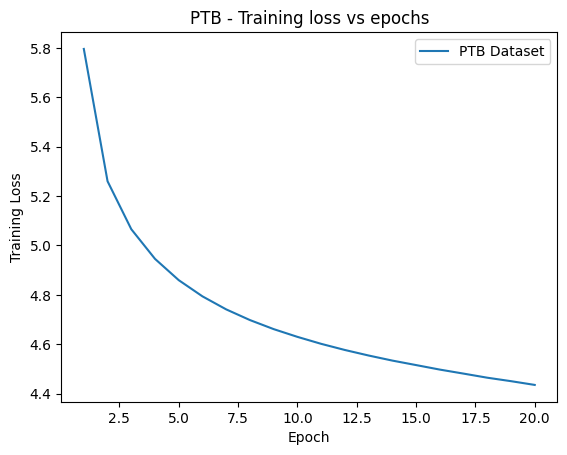

In [159]:
epochs = range(1, len(ptb_result['train_losses']) + 1)

plt.figure()
plt.plot(epochs, ptb_result['train_losses'], label='PTB Dataset')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("PTB - Training loss vs epochs")
plt.legend()
plt.show()

In [155]:
print(f"Training on WikiText-2 dataset with vocab size as {wt_vocab}")
wt_result = run_transformer_experiment_word_dataset(base_arch_config, wt_train, wt_valid, wt_test, wt_vocab)

Training on WikiText-2 dataset with vocab size as 33277


/var/folders/ns/qr_kywms25j5kcfspdm74gdc0000gn/T/ipykernel_89834/1342032880.py:82: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model, display=False, depth=None) as fcm:


Epoch - 1 | Train loss:- 6.1001 | Valid loss:- 5.6298 | FLOPs:- 144945391861760
Epoch - 2 | Train loss:- 5.5636 | Valid loss:- 5.5089 | FLOPs:- 289890783723520
Epoch - 3 | Train loss:- 5.3805 | Valid loss:- 5.4310 | FLOPs:- 434836175585280
Epoch - 4 | Train loss:- 5.2659 | Valid loss:- 5.3900 | FLOPs:- 579781567447040
Epoch - 5 | Train loss:- 5.1804 | Valid loss:- 5.3869 | FLOPs:- 724726959308800
Epoch - 6 | Train loss:- 5.1170 | Valid loss:- 5.3620 | FLOPs:- 869672351170560
Epoch - 7 | Train loss:- 5.0700 | Valid loss:- 5.3731 | FLOPs:- 1014617743032320
Epoch - 8 | Train loss:- 5.0333 | Valid loss:- 5.3516 | FLOPs:- 1159563134894080
Epoch - 9 | Train loss:- 5.0010 | Valid loss:- 5.3399 | FLOPs:- 1304508526755840
Epoch - 10 | Train loss:- 4.9696 | Valid loss:- 5.3496 | FLOPs:- 1449453918617600
Epoch - 11 | Train loss:- 4.9409 | Valid loss:- 5.3304 | FLOPs:- 1594399310479360
Epoch - 12 | Train loss:- 4.9160 | Valid loss:- 5.3357 | FLOPs:- 1739344702341120
Epoch - 13 | Train loss:- 4.890

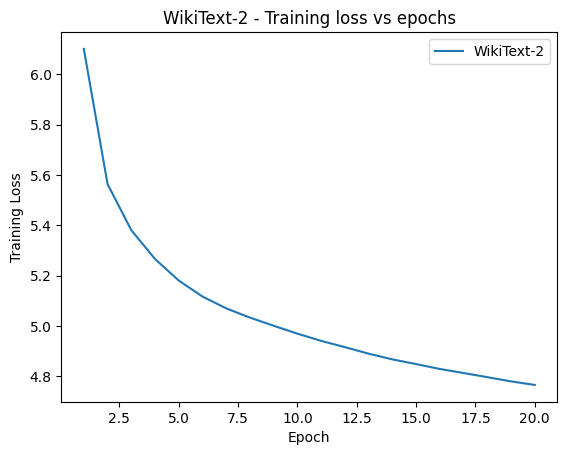

In [170]:
epochs = range(1, len(wt_result['train_losses']) + 1)

plt.figure()
plt.plot(epochs, wt_result['train_losses'], label='WikiText-2')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("WikiText-2 - Training loss vs epochs")
plt.legend()
plt.show()

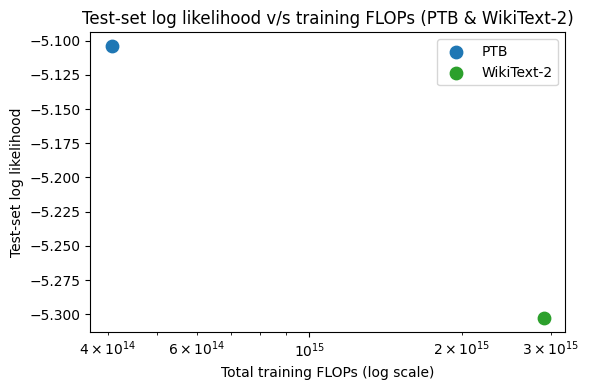

In [167]:
x_vals = [ptb_result['total_flops'], wt_result['total_flops']]

plt.figure(figsize=(6,4))
colors = ['tab:blue', 'tab:green']

for x, y, lab, col in zip(x_vals, y_vals, labels, colors):
    plt.scatter(x, y, color=col, s=80, label=lab)

plt.xscale('log')
plt.xlabel("Total training FLOPs (log scale)")
plt.ylabel("Test-set log likelihood")
plt.title("Test-set log likelihood v/s training FLOPs (PTB & WikiText-2)")
plt.legend()
plt.tight_layout()
plt.show()

In [182]:
def generate_text_word(model, prompt, max_new_tokens, block_size, stoi, itos):
    model.eval()
    words = prompt.strip().split()
    context = [stoi.get(w, 0) for w in words]
    generated = context[:]

    for _ in range(max_new_tokens):
        ctx = generated[-block_size:]
        if len(ctx) < block_size:
            ctx = [0] * (block_size - len(ctx)) + ctx
        x = torch.tensor([ctx], dtype=torch.long, device=device)
        logits = model(x) 
        logits_last = logits[:, -1, :]
        probs = torch.softmax(logits_last[0], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_id)

    out_words = [itos[i] for i in generated]
    return " ".join(out_words)

ptb_model = ptb_result['model']
wt_model  = wt_result['model']

sample_ptb = generate_text_word(ptb_model, prompt="the school announced that", max_new_tokens=100, block_size=16, stoi=ptb_stoi, itos=ptb_itos)

print("\nGenerated Sample for PTB Dataset\n")
print(sample_ptb)

sample_wt = generate_text_word(wt_model, prompt="The history of machine learning begins",max_new_tokens=100,block_size=16,stoi=wt_stoi,itos=wt_itos)

print("\nGenerated Sample for WikiText-2 Dataset\n")
print(sample_wt)


Generated Sample for PTB Dataset

the school announced that analysts were with the week ended friday 's dealers said the offer added from about N billion lire $ N this year and were up N N from the $ N million loss <unk> on its carpet quality schedule are high instead of a truck maker the steel and engines products lost N to N the steel hit a <unk> call television <unk> aircraft n.v. had net income of $ N billion up N N from $ N million or N cents a share or about $ N million or $ N a share changed from $ N million in

Generated Sample for WikiText-2 Dataset

The history of machine learning begins with the children being done . In 1935 , Valve began working during the first aided by Madrid biographer Benoît Assessment . He claimed that Patterson had a site , and through the corner was short until a failed east . She was asked to Commander Blaine with a New York by Arsenal to play the ship of <unk> ( " sink " seat " All Good Things Hale and an area work in the New York corruption , whi